In [67]:
import os
import sys
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

import umap
import umap.plot


import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(context='notebook', style='white', rc={'figure.figsize':(11,11)})

In [2]:
sys.path.append('../gan-vae-pretrained-pytorch')

#### GAN

In [3]:
# load the models
from mnist_dcgan.dcgan import Discriminator, Generator

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_dcgan/weights/netD_epoch_99.pth'))
G.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_dcgan/weights/netG_epoch_99.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()


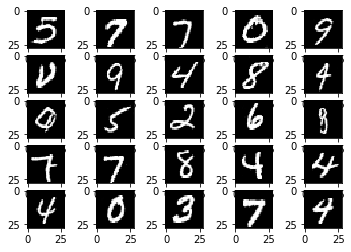

In [4]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()


In [5]:
outputs = D(fake_images)
print(outputs)
print(outputs.mean())

tensor([0.0850, 0.0592, 0.7288, 0.0386, 0.0365, 0.0315, 0.0457, 0.0203, 0.4845,
        0.3682, 0.1448, 0.1403, 0.3662, 0.8672, 0.1182, 0.1678, 0.2231, 0.3561,
        0.1011, 0.5551, 0.2423, 0.1940, 0.0666, 0.1596, 0.2318],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.2333, device='cuda:0', grad_fn=<MeanBackward0>)


#### Classifier

In [6]:
from mnist_classifier.lenet import LeNet5
from torchvision.datasets.mnist import MNIST

In [7]:
classifier = LeNet5().eval()
classifier.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_classifier/weights/lenet_epoch=12_test_acc=0.991.pth'))
if torch.cuda.is_available():
    classifier = classifier.cuda()

In [8]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

data_root = '~/mnist'
data_test = MNIST(data_root,
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize(28),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,), (0.5,))]))
data_loader = torch.utils.data.DataLoader(data_test, 
                                          batch_size=10000,
                                          shuffle=False)
(ims, labs) = next(iter(data_loader)) # get whole dataset
if torch.cuda.is_available():
    ims = ims.cuda()
labs = labs.numpy()

In [9]:
ims.shape

torch.Size([10000, 1, 28, 28])

In [10]:
fake_images.shape

torch.Size([25, 1, 28, 28])

#### Feature Extractor

In [58]:
class FeatureExtractor:
    def __init__(self):
        feat_extractor = LeNet5().eval()
        feat_extractor.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_classifier/weights/lenet_epoch=12_test_acc=0.991.pth'))
        if torch.cuda.is_available():
            feat_extractor = feat_extractor.cuda()
        feat_extractor.eval()
        
        self.feat_extractor = feat_extractor
        self.fc = []
        
        feat_extractor.fc.f6.register_forward_hook(self._hook)
        
    def _hook(self, module, input, output):
        self.fc.append(output)
        
    def get_feats(self, images):
        ims = images.cuda()
        if images.shape[-1] == 28:
            ims = nn.functional.interpolate(ims, size=32).cuda()
        
        self.fc = []
        with torch.no_grad():
            self.feat_extractor(ims)
            
        return self.fc[0]
    

In [59]:
feature_extractor = FeatureExtractor()

#### Perturbation network

In [141]:
def get_perturb_network():
    model = nn.Sequential(
        nn.Linear(latent_size, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size)
    ).cuda()

    # Initialize to identify weight matrix (as if nothing is happening)
    with torch.no_grad():
        for layer in model:
            if type(layer) == nn.Linear:
                layer.weight = nn.Parameter(torch.eye(latent_size).cuda())
                layer.bias = nn.Parameter(torch.zeros(latent_size).cuda())
                
    return model

#### Visualization

In [142]:
def umap_plot_images(embs, labels, images, xlim=None, ylim=None, cmap='bwr', show_legend=False):
    fig = plt.figure(figsize=(38,19), dpi=32, constrained_layout=False)

    grid_size=5

    # fig.tight_layout()
    gs = fig.add_gridspec(grid_size, grid_size*2, wspace=0, hspace=0)
    umap_ax = fig.add_subplot(gs[:, :grid_size])
    im_axes = []
    for i in range(grid_size):
        for j in range(grid_size):
            im_axes.append(fig.add_subplot(gs[i, j+grid_size]))
            im_axes[-1].set_axis_off()
    #         im_axes[-1].set(xticks=[], yticks=[])

    for i in range(grid_size**2):
        im_axes[i].imshow(images[i][0], aspect='auto', cmap='gray')

    scatter = umap_ax.scatter(embs[:,0], embs[:,1], s = 1, c = labels, cmap=cmap)
    if show_legend:
        # produce a legend with the unique colors from the scatter
        legend1 = umap_ax.legend(*scatter.legend_elements(),
                            title="", fontsize=25, markerscale=4)
        umap_ax.add_artist(legend1)
    umap_ax.get_xaxis().set_ticks([])
    umap_ax.get_yaxis().set_ticks([])
    umap_ax.set_axis_off()
    if xlim is not None and ylim is not None:
        umap_ax.set_xlim(xlim)
        umap_ax.set_ylim(ylim)
    
    return fig

def plot_two_types(emb1, emb2, images):
    all_embs_labels = np.concatenate((np.zeros(emb1.shape[0]), np.ones(emb2.shape[0])))
    all_embs = np.concatenate((emb1, emb2))
    xlim = [min(emb1[:,0])*1.1, max(emb1[:,0])*1.1]
    ylim = [min(emb1[:,1])*1.1, max(emb1[:,1])*1.1]
    return umap_plot_images(all_embs, all_embs_labels, images, xlim=xlim, ylim=ylim) #cmap='Spectral', show_legend=True)

#### Loss

In [218]:

batch_size = 512
latent_size = 100

def show_images(ims):
    ims = ims.cpu().detach().numpy()[:25]
    ims = ims.reshape(ims.shape[0], ims.shape[-1], ims.shape[-1])
    R, C = 5, 5
    for i in range(ims.shape[0]):
        plt.subplot(R, C, i + 1)
        plt.imshow(ims[i], cmap='gray')
    plt.show()


def gen_noise(bs, dim=latent_size, class_tensor=None, num_classes=None):
    return torch.randn(bs, dim).cuda()

def noise_with_class(noise, class_tensor, num_classes):
    assert num_classes > max(class_tensor)
    noise[:,0:num_classes] = 0
    noise[torch.arange(len(noise)), class_tensor] = 1
    return noise

In [144]:
def gen_images(noise, perturb=None):
    if perturb is not None:
        noise_p = perturb(noise)
    else:
        noise_p = noise
    noise_p_lg = noise_p.unsqueeze(-1).unsqueeze(-1)

    images = G(noise_p_lg)
    images_interp = nn.functional.interpolate(images, size=32)
    preds = torch.exp(classifier(images_interp))
    
    disc_score = D(images)
    
    return noise_p, images, preds, disc_score

In [216]:
def train(perturb, class_weight=1, perturb_weight=1, disc_weight=1, iters=300, 
          save_dir=None, feature_extractor=None, mapping=None, real_embeds=None, conditional=False):
    
    if not (save_dir is None and mapping is None and real_embeds is None and feature_extractor is None):
        if not (save_dir is not None and mapping is not None and real_embeds is not None and feature_extractor is not None):
            print("dawg give it to me straight")
            return
    
    
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    
    optimizer = torch.optim.Adam(perturb.parameters())
    
    class_loss_fn = nn.CrossEntropyLoss()
    perturb_loss_fn = nn.MSELoss()
    disc_loss_fn = nn.BCELoss()
    
    # noise for visualiztion
    vis_noise = gen_noise(25)

    losses = []
    for i in range(iters):

        # Train one iteration
        optimizer.zero_grad()
        
        
        noise = gen_noise(batch_size)
        
        if conditional:
            target = torch.randint(0, 9, (batch_size,)).cuda()
            noise = noise_with_class(noise, target, 10)
        else:
            target = torch.ones(batch_size).long().cuda()

        noise_p, images, preds, disc_score = gen_images(noise, perturb)
        
        disc_target = torch.ones(batch_size).cuda() # 1 = real
         
        class_loss = class_loss_fn(preds, target)
        perturb_loss = perturb_loss_fn(noise_p, noise)
        disc_loss = disc_loss_fn(disc_score, disc_target)
        
        loss = class_weight * class_loss + perturb_weight * perturb_loss + disc_weight * disc_loss

        loss.backward()
        optimizer.step()
        
        # Visualization
        
        if save_dir is not None and i % 3 == 0:
            with torch.no_grad():
                
                _, images, _, _ = gen_images(gen_noise(3072), perturb)
                image_feats = feature_extractor.get_feats(images).cpu().numpy()
                new_embeds = mapping.transform(image_feats)
                
                _, images, _, _ = gen_images(vis_noise, perturb)
                fig = plot_two_types(real_embeds, new_embeds, images.detach().cpu().numpy())
                
                filename = os.path.join(save_dir, 'frame'+str(i)+'.png')
                fig.savefig(filename, dpi=72)
                plt.close(fig)

        losses.append(loss.item())
        if i % 50 == 0:
            print('Iter', i, '-- Loss', loss.item())
            
    return losses


#### class=1, perturb=0, disc=0

In [238]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=0, disc_weight=0)

Iter 0 -- Loss 2.339259147644043
Iter 50 -- Loss 1.8719520568847656
Iter 100 -- Loss 1.7921626567840576
Iter 150 -- Loss 1.7645868062973022
Iter 200 -- Loss 1.780320644378662
Iter 250 -- Loss 1.737691879272461


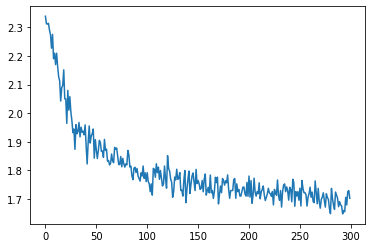

In [239]:
plt.plot(losses)

In [240]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)

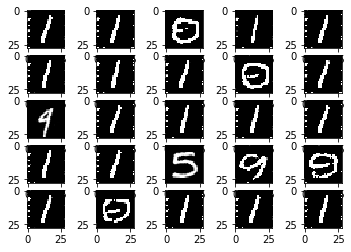

In [241]:
show_images(images)

In [242]:
preds.argmax(-1)

tensor([1, 1, 5, 1, 1, 1, 1, 1, 0, 1, 9, 1, 1, 1, 1, 1, 1, 5, 9, 5, 1, 5, 1, 1,
        1], device='cuda:0')

#### class=1, perturb=1, disc=0

Iter 0 -- Loss 3.144253730773926
Iter 50 -- Loss 2.155863046646118
Iter 100 -- Loss 2.141364097595215
Iter 150 -- Loss 2.115186929702759
Iter 200 -- Loss 2.1173036098480225
Iter 250 -- Loss 2.1008036136627197


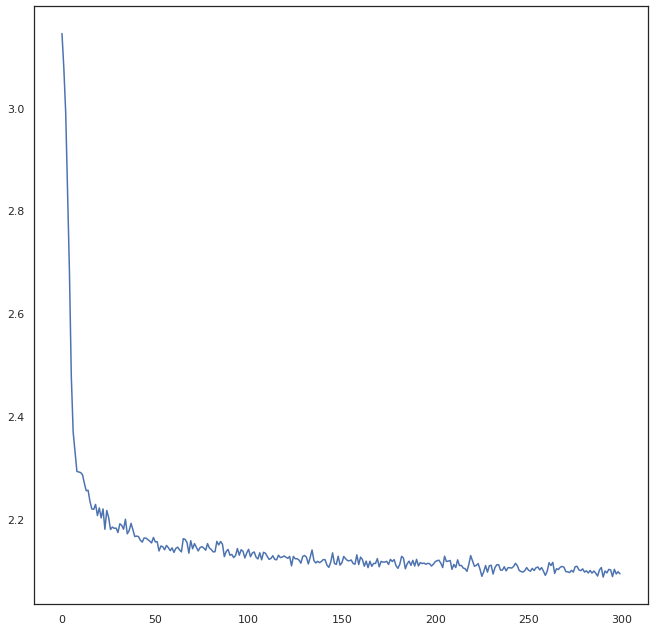

In [221]:
perturb = get_perturb_network()
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, iters=300)
plt.plot(losses)

tensor([7, 1, 7, 7, 5, 3, 5, 7, 7, 2, 8, 3, 4, 4, 2, 1, 2, 3, 4, 1, 7, 8, 9, 7,
        6], device='cuda:0')
Mean Disc loss:  0.27611044049263


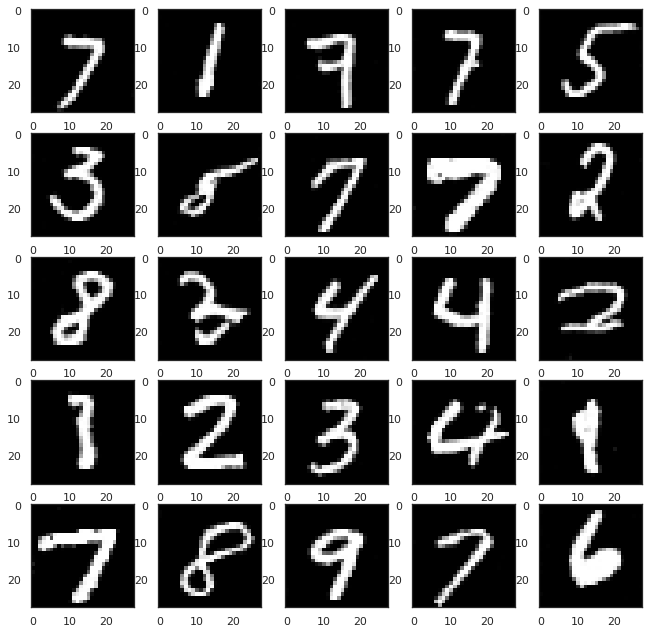

In [224]:
noise = gen_noise(25)
noise_p, images, preds, disc_score = gen_images(noise, None)

print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### 1,1,0.1

Iter 0 -- Loss 2.813302755355835
Iter 50 -- Loss 2.6976397037506104
Iter 100 -- Loss 2.647486448287964
Iter 150 -- Loss 2.6014420986175537
Iter 200 -- Loss 2.459306240081787
Iter 250 -- Loss 2.412752628326416
Iter 300 -- Loss 2.3722095489501953
Iter 350 -- Loss 2.2838873863220215
Iter 400 -- Loss 2.197545051574707
Iter 450 -- Loss 2.187534809112549
Iter 500 -- Loss 2.15803861618042
Iter 550 -- Loss 2.137561082839966
Iter 600 -- Loss 2.147799015045166
Iter 650 -- Loss 2.097907781600952
Iter 700 -- Loss 2.1446869373321533
Iter 750 -- Loss 2.096592426300049
Iter 800 -- Loss 2.0930752754211426
Iter 850 -- Loss 2.126528739929199
Iter 900 -- Loss 2.092851400375366
Iter 950 -- Loss 2.067260503768921


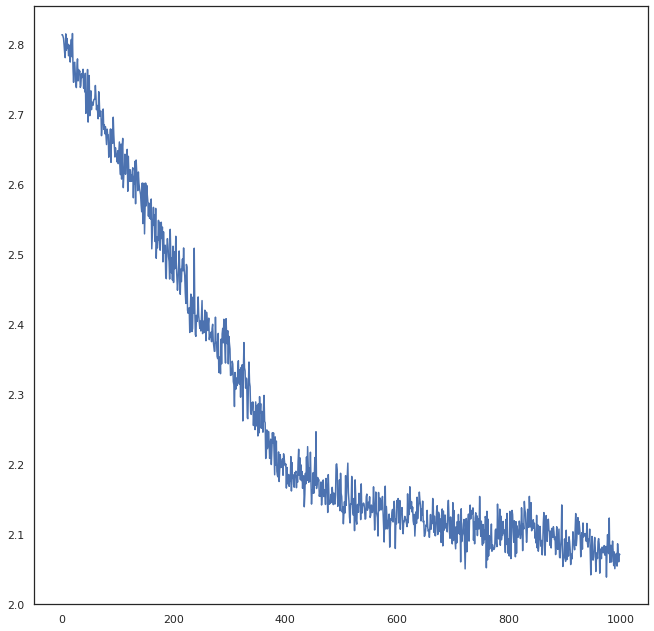

In [239]:
# Now, conditionally:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=0.5, disc_weight=0.05, iters=1000, conditional=True)
plt.plot(losses)

tensor([7, 4, 2, 1, 5, 1, 2, 3, 0, 3, 4, 3, 1, 7, 0, 1, 4, 4, 3, 5, 4, 5, 0, 4,
        2], device='cuda:0')
tensor([7, 1, 2, 1, 5, 1, 2, 3, 0, 3, 4, 3, 1, 1, 0, 1, 4, 4, 8, 5, 8, 5, 0, 4,
        2], device='cuda:0')
Mean Disc loss:  0.3738105595111847


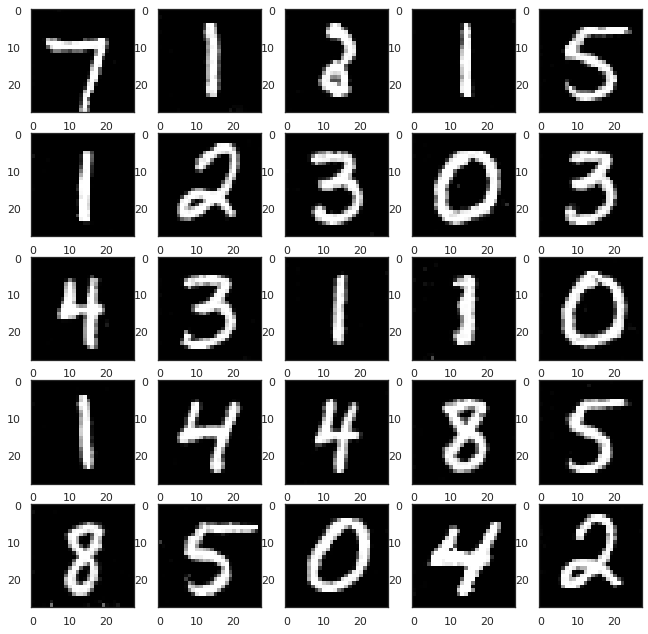

In [242]:
classes = torch.randint(0, 9, (25,)).cuda() #torch.ones(25).long().cuda()*2#
noise = gen_noise(25)
noise_p, images, preds, disc_score = gen_images(noise_with_class(noise, classes, 10), perturb)
# noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(classes)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

tensor([1, 6, 2, 2, 0, 3, 2, 9, 3, 5, 5, 7, 2, 2, 7, 4, 7, 5, 8, 8, 3, 4, 7, 2,
        9], device='cuda:0')
Mean Disc loss:  0.15276014804840088


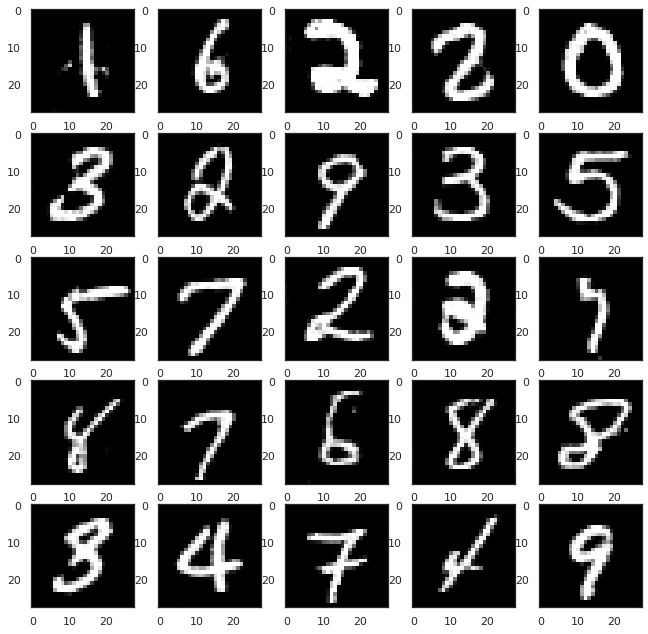

In [243]:
# Generate with same noise, but not conditinally
noise_p, images, preds, disc_score = gen_images(noise, None)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=10

Iter 0 -- Loss 22.689807891845703
Iter 50 -- Loss 22.109020233154297
Iter 100 -- Loss 20.55162811279297
Iter 150 -- Loss 18.349477767944336
Iter 200 -- Loss 16.001930236816406
Iter 250 -- Loss 14.418083190917969
Iter 300 -- Loss 13.935626983642578
Iter 350 -- Loss 13.079444885253906
Iter 400 -- Loss 11.146703720092773
Iter 450 -- Loss 9.864684104919434
Iter 500 -- Loss 8.256194114685059
Iter 550 -- Loss 5.993600845336914
Iter 600 -- Loss 5.265566825866699
Iter 650 -- Loss 4.917550086975098
Iter 700 -- Loss 4.23323917388916
Iter 750 -- Loss 4.299526214599609
Iter 800 -- Loss 4.154753684997559
Iter 850 -- Loss 3.745466709136963
Iter 900 -- Loss 3.459221839904785
Iter 950 -- Loss 3.376338243484497


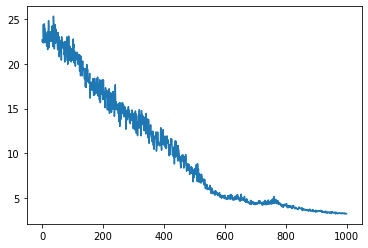

In [246]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=10, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.931740403175354


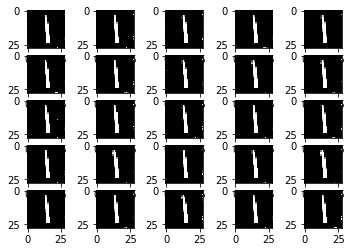

In [247]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=1

Iter 0 -- Loss 4.342452526092529
Iter 50 -- Loss 4.343758583068848
Iter 100 -- Loss 4.296798229217529
Iter 150 -- Loss 4.000028610229492
Iter 200 -- Loss 3.7808709144592285
Iter 250 -- Loss 3.7091588973999023
Iter 300 -- Loss 3.2532858848571777
Iter 350 -- Loss 2.9648799896240234
Iter 400 -- Loss 2.695672035217285
Iter 450 -- Loss 2.4445652961730957
Iter 500 -- Loss 2.3015124797821045
Iter 550 -- Loss 2.201127767562866
Iter 600 -- Loss 2.1183526515960693
Iter 650 -- Loss 2.0582480430603027
Iter 700 -- Loss 2.0080113410949707
Iter 750 -- Loss 1.9744704961776733
Iter 800 -- Loss 1.9462461471557617
Iter 850 -- Loss 1.9280515909194946
Iter 900 -- Loss 1.8829634189605713
Iter 950 -- Loss 1.7947810888290405


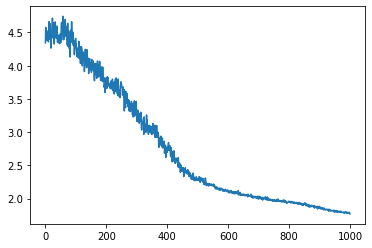

In [248]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=1, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.9085697531700134


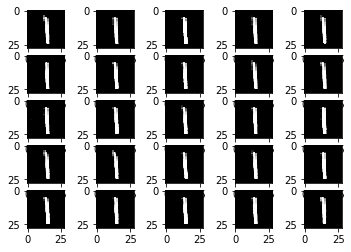

In [249]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

In [250]:
torch.softmax(preds, -1)[0].sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

#### class=1, perturb=1, disc=0.1

Iter 0 -- Loss 2.561955690383911
Iter 50 -- Loss 2.332526683807373
Iter 100 -- Loss 2.150678873062134
Iter 150 -- Loss 2.0226593017578125
Iter 200 -- Loss 1.829315423965454
Iter 250 -- Loss 1.7463833093643188
Iter 300 -- Loss 1.7073520421981812
Iter 350 -- Loss 1.651883602142334
Iter 400 -- Loss 1.6472777128219604
Iter 450 -- Loss 1.6412445306777954
Iter 500 -- Loss 1.64120352268219
Iter 550 -- Loss 1.6505237817764282
Iter 600 -- Loss 1.6399091482162476
Iter 650 -- Loss 1.6263082027435303
Iter 700 -- Loss 1.6240373849868774
Iter 750 -- Loss 1.622225046157837
Iter 800 -- Loss 1.6253957748413086
Iter 850 -- Loss 1.619353175163269
Iter 900 -- Loss 1.6032816171646118
Iter 950 -- Loss 1.6168516874313354


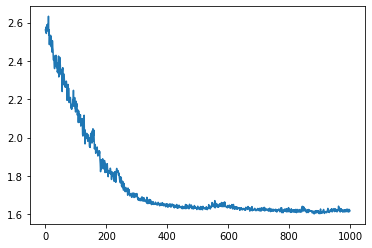

In [251]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0.1, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.5940985083580017


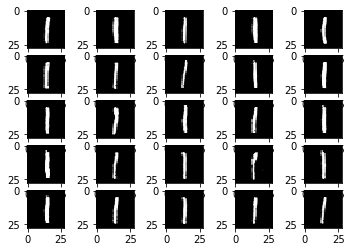

In [252]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=0.01

Iter 0 -- Loss 2.381848096847534
Iter 50 -- Loss 2.109687328338623
Iter 100 -- Loss 1.9615917205810547
Iter 150 -- Loss 1.9207170009613037
Iter 200 -- Loss 1.7051924467086792
Iter 250 -- Loss 1.6204783916473389
Iter 300 -- Loss 1.6165738105773926
Iter 350 -- Loss 1.5759223699569702
Iter 400 -- Loss 1.5696383714675903
Iter 450 -- Loss 1.5886493921279907
Iter 500 -- Loss 1.561998724937439
Iter 550 -- Loss 1.5467408895492554
Iter 600 -- Loss 1.5357848405838013
Iter 650 -- Loss 1.5517852306365967
Iter 700 -- Loss 1.5464978218078613
Iter 750 -- Loss 1.5344576835632324
Iter 800 -- Loss 1.5525546073913574
Iter 850 -- Loss 1.5935688018798828
Iter 900 -- Loss 1.5767287015914917
Iter 950 -- Loss 1.5787477493286133


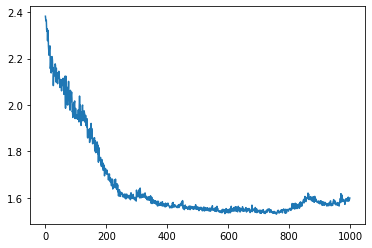

In [257]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0.01, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.2925819456577301


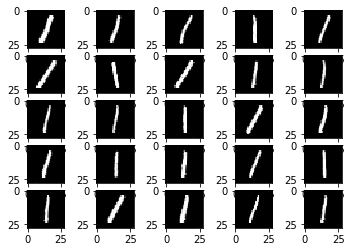

In [259]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=0.05

Iter 0 -- Loss 2.453378677368164
Iter 50 -- Loss 2.22053599357605
Iter 100 -- Loss 2.0463058948516846
Iter 150 -- Loss 1.854372262954712
Iter 200 -- Loss 1.793121576309204
Iter 250 -- Loss 1.6907340288162231
Iter 300 -- Loss 1.6379029750823975
Iter 350 -- Loss 1.6432545185089111
Iter 400 -- Loss 1.619269609451294
Iter 450 -- Loss 1.612392783164978


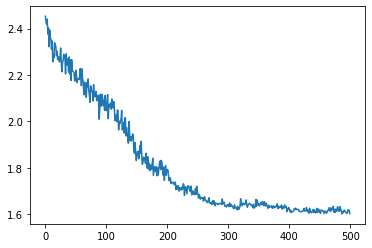

In [15]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0.05, iters=500)
plt.plot(losses)

tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.3729730248451233


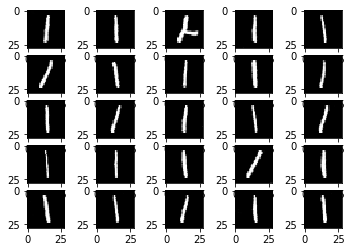

In [16]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

# Josh

In [20]:
(ims, labs) = next(iter(data_loader))

In [21]:
# show_images(nn.functional.interpolate(ims, size=28))

In [22]:
ones = ims[labs==1]

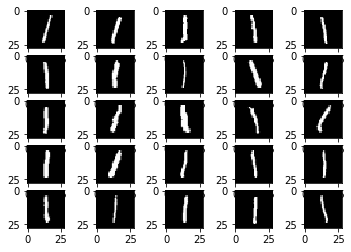

In [23]:
show_images(nn.functional.interpolate(ones, size=28))

In [24]:
ims.shape

torch.Size([10000, 1, 28, 28])

In [63]:
real_feats = feature_extractor.get_feats(ims).cpu().numpy()

In [64]:
mapper = umap.UMAP().fit(real_feats)

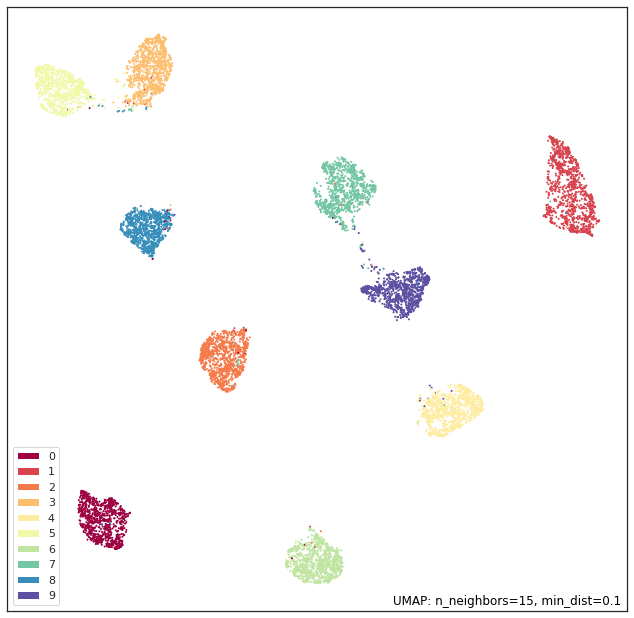

In [65]:
umap.plot.points(mapper, labels=labs)

In [66]:
real_embs = mapper.transform(real_feats)

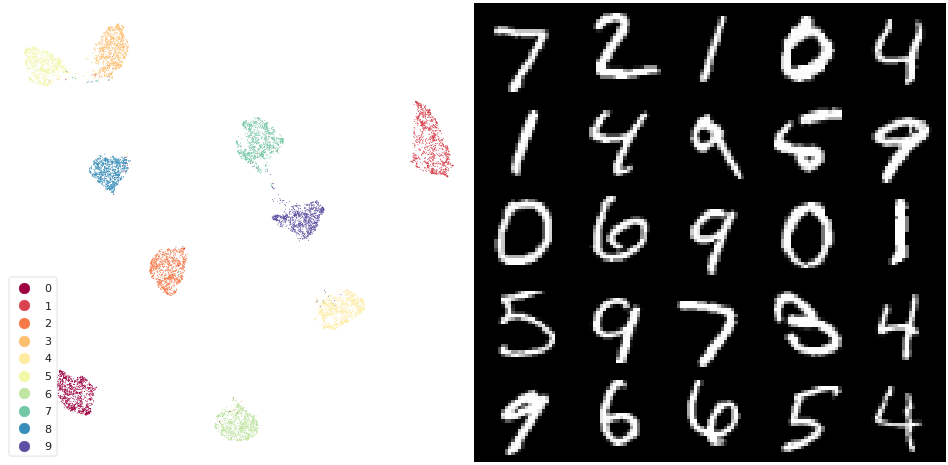

In [68]:
plot = umap_plot_images(real_embs, labs, ims.cpu(), cmap='Spectral', show_legend=True)

In [38]:
sample_size = 1024
images_fake = []
with torch.no_grad():
    for i in range(10):
        _, images, _, _ = gen_images(gen_noise(sample_size))
        images_fake.append(images)
images_fake = torch.cat(images_fake)

In [39]:
images_fake.shape

torch.Size([10240, 1, 28, 28])

In [69]:
fake_feats = feature_extractor.get_feats(images_fake).cpu().numpy()

In [71]:
fake_embeds = mapper.transform(fake_feats)
fake_embeds.shape

(10240, 2)

In [251]:
sample_size = 3072
classes = torch.randint(0, 9, (sample_size,)).cuda()
noise = noise_with_class(gen_noise(sample_size), classes, 10)
_, images_perturbed, _, _ = gen_images(noise, perturb)
# show_images(images)

In [252]:
one_feats = feature_extractor.get_feats(images_perturbed).cpu().numpy()

In [253]:
one_feats.shape

(3072, 84)

In [254]:
one_embs = mapper.transform(one_feats)

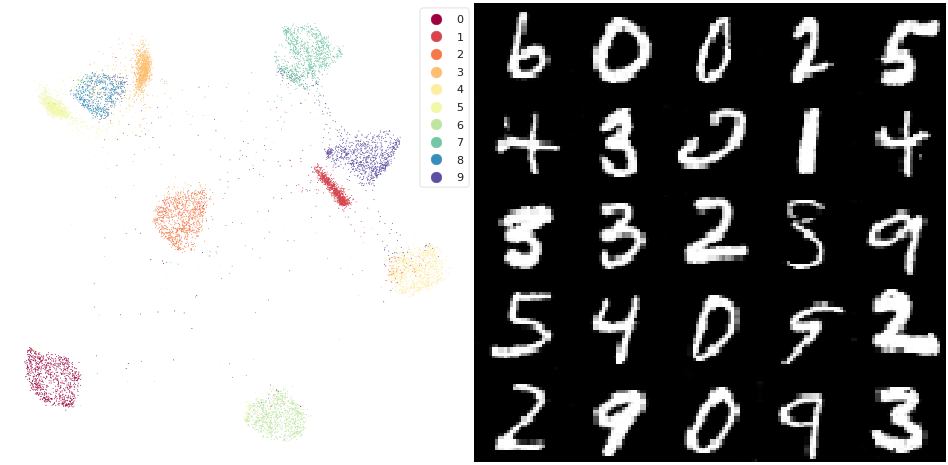

In [76]:
fake_labels = classifier(fake_interp).detach().cpu().numpy().argmax(-1)
plot = umap_plot_images(fake_embeds, fake_labels, fake_interp[:25].detach().cpu().numpy(), cmap='Spectral', show_legend=True)

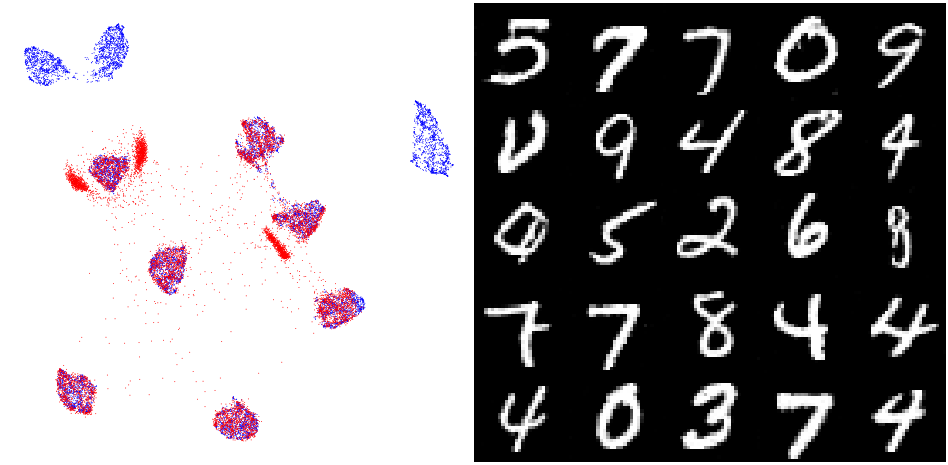

In [77]:
plot = plot_two_types(real_embs, fake_embeds, fake_images[:25].detach().cpu().numpy())

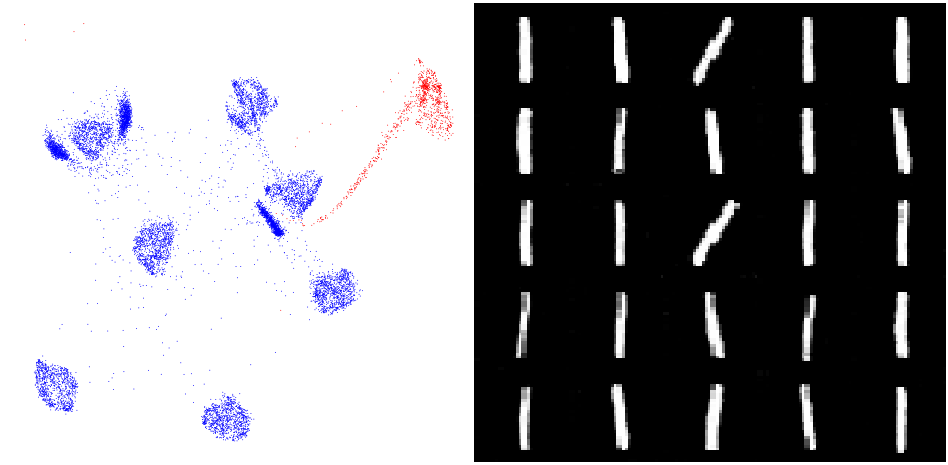

In [78]:
# plot = umap_plot_images(fake_embeds, fake_labels, fake_interp[:25].detach().cpu().numpy(),cmap='Spectral', show_legend=True)
plot = plot_two_types(fake_embeds, one_embs, ones_interp[:25].detach().cpu().numpy())

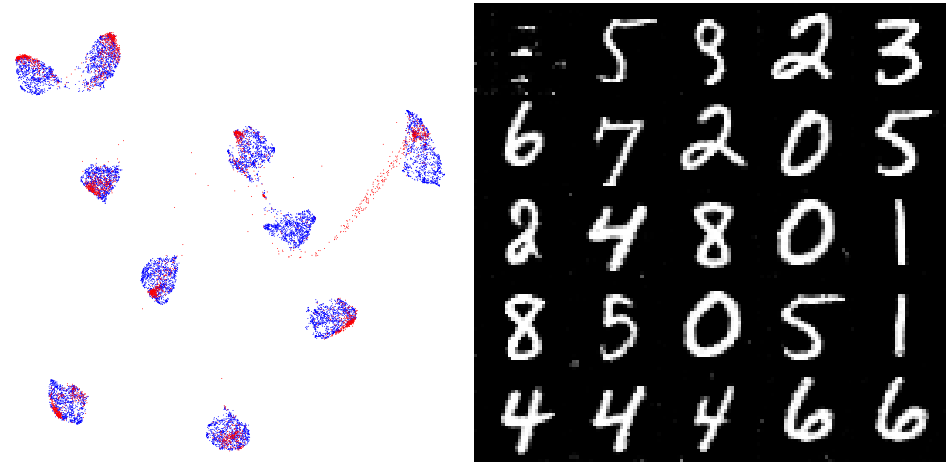

In [255]:
# plot = umap_plot_images(fake_embeds, fake_labels, fake_interp[:25].detach().cpu().numpy(),cmap='Spectral', show_legend=True)
plot = plot_two_types(real_embs, one_embs, images_perturbed[:25].detach().cpu().numpy())

In [51]:
# plot.savefig('temp.png', dpi=72)